# Notes

* Pole placement! 

* Reference: https://www.youtube.com/watch?v=FXSpHy8LvmY&list=PLn8PRpmsu08podBgFw66-IavqU2SqPg_w&index=2

In [51]:
import numpy as np
import control.matlab as matlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

State space form:
* $\dot x = A \cdot x + B \cdot u$
* $y = C \cdot x + D \cdot u$

In [52]:
A = np.array([[0, 1], [2, -1]])
B = np.array([[1], [0]])
C = np.array([[1, 0]])
D = np.array([[0]])

sys = matlab.ss(A, B, C, D)

sys

<LinearIOSystem:sys[15]:['u[0]']->['y[0]']>

Eigenvalues of $A$ are the poles of the system.

In [53]:
# find eigenvalues of A
eigvals, eigvecs = np.linalg.eig(A)

eigvals

array([ 1., -2.])

If we have at least one eigenvalue with positive real part, the system is unstable.

<img src="eigenvalues.png" width=500>

To solve that, we need a pole placement controller.

In [54]:
# desired eigenvalues (we corrected the 1 to -1 for establishing stability)
P = np.array([-2, -1])

# hard math to find eigenvalues of A - BK
K = matlab.place(A, B, P)
K

matrix([[2., 1.]])

now that we have K feedback, we can create the closed loop system:

$\dot x = (A - B \cdot K) \cdot x$

In [55]:
Acl = A - B @ K

eigvals, eigvecs = np.linalg.eig(Acl)

eigvals

array([-1., -2.])

In [56]:
syscl = matlab.ss(Acl, B, C, D)

syscl

<LinearIOSystem:sys[16]:['u[0]']->['y[0]']>

Now we can compare both step responses

Note that, A open loop is unstable and Acl closed loop is stable.

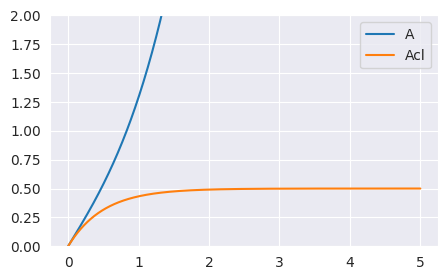

y(∞) = 98.44
ycl(∞) = 0.50


In [57]:
# step response of A and Acl
t = np.linspace(0, 5, 1000)
y, t = matlab.step(sys, t)
ycl, t = matlab.step(syscl, t)

fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(t, y, label='A')
ax.plot(t, ycl, label='Acl')
ax.legend()

# limit y axis
plt.ylim(0, 2)
plt.show()

# print "infinity" values of y and ycl
print(f'y(∞) = {y[-1]:.2f}')
print(f'ycl(∞) = {ycl[-1]:.2f}')

we also need to solve for the DC gain 

In [58]:
kdc = matlab.dcgain(syscl)
kr = 1/kdc 

kdc, kr

(0.5, 2.0)

In [59]:
syscl_scaled = matlab.ss(Acl, B*kr, C, D) # B*kr is the new B matrix

syscl_scaled

<LinearIOSystem:sys[17]:['u[0]']->['y[0]']>

Agora podemos forçar a convergência do sistema para 1, por exemplo.

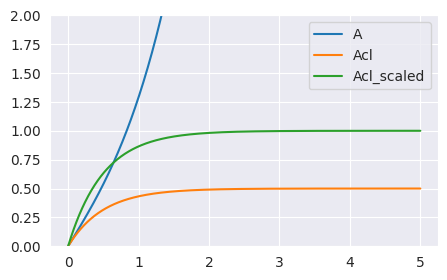

In [60]:
# step response of all systems

y_scaled, t = matlab.step(syscl_scaled, t)

fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(t, y, label='A')
ax.plot(t, ycl, label='Acl')
ax.plot(t, y_scaled, label='Acl_scaled')

ax.legend()
plt.ylim(0, 2)
plt.show()

# PD Controller compared to Pole Placement

Teorically we can use a PD controller to force the system to converge to 1, the same way a pole placement system would do. 

<img src="PD_controller.png" width=500>

Controller: 
0.5 s + 5
---------
    1

System: 
   s + 1
-----------
s^2 + s - 2

Closed-Loop System: 
0.5 s^2 + 5.5 s + 5
-------------------
0.5 s^2 - 4.5 s - 7

y(∞) = 10.00


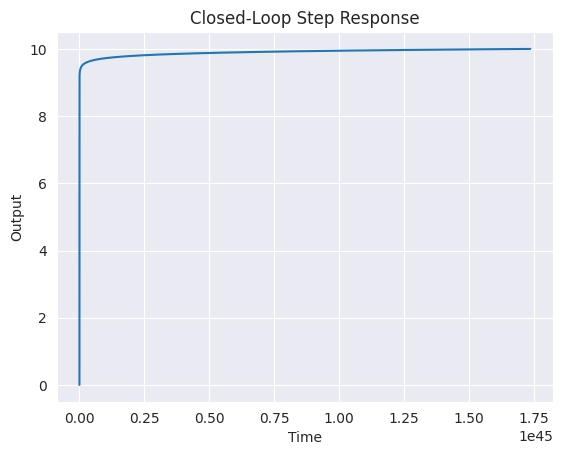

In [113]:
# Define PD controller gains (tune these values)
Kp = 5
Kd = 0.5

# Create the closed-loop transfer function by connecting the system and controller in feedback
s = matlab.tf('s')
controller_tf = (Kp + Kd*s)
sys_tf = matlab.tf(sys)
closed_loop_sys = matlab.feedback(sys_tf*controller_tf, -1)

# print tfs
print(f'Controller: {controller_tf}')
print(f'System: {sys_tf}')
print(f'Closed-Loop System: {closed_loop_sys}')


# Define time vector for simulation
t = np.linspace(0, 10, 1000)

# Step response of the closed-loop system
time, response = matlab.step(closed_loop_sys, T=t)

# steady-state value
print(f'y(∞) = {response[-1]:.2f}')

# Plot the step response
plt.plot(time, response)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('Closed-Loop Step Response')
plt.grid(True)
plt.show()